## Mnist Clan-ssifier ;)

Here we demonstrate how to use the EZKL package to build an MNIST classifier for on-chain handrawn digit recognition.
The proofs get submitted to a contract that assigns the users account to a digit clan (0-9). The contract keeps track of the member count of each clan. The clan with the most members is the winner!

![zk-gaming-diagram-transformed](https://file.notion.so/f/f/f9535faf-4480-4499-9059-a48ba240eaa9/cd13414a-ecd8-4b8f-90a1-8a2311baa278/Untitled.png?id=365d66ee-e653-4ec3-8eb6-6d2b6306455a&table=block&spaceId=f9535faf-4480-4499-9059-a48ba240eaa9&expirationTimestamp=1701568800000&signature=VJ9p3YsOjYjeLxmkVEWOJw_3VmM6IBkTYxMwQUFKeus&downloadName=Untitled.png)

> **A typical ZK application flow**. For all the image classifictiton hackers out there — this is an fairly straight forward example. A user computes a ZKML-proof that they have calculated a valid classification of a hand drawn digit from a MNIST trained lenet model. They submit this proof to a verifier contract which governs a set of clans, along with the output values of the model (length 10 tensor whereby the index with the max value represented the prediction), and the clan count updates according the lenets model's prediction.


In [1]:
# check if notebook is in colab
try:
    # install ezkl
    import google.colab
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ezkl"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "torch"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "torchvision"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "tf2onnx"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "onnx"])

# rely on local installation of ezkl if the notebook is not in colab
except:
    pass

# make sure you have the dependencies required here already installed
import ezkl
import os
import json
import time
import random
import logging


# uncomment for more descriptive logging
FORMAT = '%(levelname)s %(name)s %(asctime)-15s %(filename)s:%(lineno)d %(message)s'
logging.basicConfig(format=FORMAT)
logging.getLogger().setLevel(logging.INFO)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # Convolutional encoder
        self.conv1 = nn.Conv2d(1, 6, 5)  # 1 input channel, 6 output channels, 5x5 kernel
        self.conv2 = nn.Conv2d(6, 16, 5) # 6 input channels, 16 output channels, 5x5 kernel

        # Fully connected layers / Dense block
        self.fc1 = nn.Linear(16 * 4 * 4, 120) 
        self.fc2 = nn.Linear(120, 84)         # 120 inputs, 84 outputs
        self.fc3 = nn.Linear(84, 10)          # 84 inputs, 10 outputs (number of classes)

    def forward(self, x):
        # Convolutional block
        # x = F.avg_pool2d(F.sigmoid(self.conv1(x)), (2, 2)) # Convolution -> Sigmoid -> Avg Pool
        # x = F.avg_pool2d(F.sigmoid(self.conv2(x)), (2, 2)) # Convolution -> Sigmoid -> Avg Pool
        x = F.avg_pool2d((self.conv1(x)), (2, 2)) # Convolution -> Sigmoid -> Avg Pool
        x = F.avg_pool2d((self.conv2(x)), (2, 2)) # Convolution -> Sigmoid -> Avg Pool

        # Flattening
        x = x.view(x.size(0), -1)

        # Fully connected layers
        # x = F.sigmoid(self.fc1(x))
        # x = F.sigmoid(self.fc2(x))
        x = (self.fc1(x))
        x = (self.fc2(x))
        x = self.fc3(x)  # No activation function here, will use CrossEntropyLoss later
        return x


In [3]:
import numpy as np
import os
import torch
from torchvision.datasets import mnist
from torch.nn import CrossEntropyLoss
from torch.optim import Adam  # Import Adam
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

def normalize_img(image, label):
  return torch.round(image), label

device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 256
train_dataset = mnist.MNIST(root='./train', train=True, transform=ToTensor(), download=True)
test_dataset = mnist.MNIST(root='./test', train=False, transform=ToTensor(), download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
model = LeNet().to(device)
adam = Adam(model.parameters())  # Using Adam with a learning rate of 1e-3
loss_fn = CrossEntropyLoss()
all_epoch = 25
prev_acc = 0
for current_epoch in range(all_epoch):
    model.train()
    for idx, (train_x, train_label) in enumerate(train_loader):
        train_x = train_x.to(device)
        # normalize the image to 0 or 1 to reflect the inputs from the drawing board
        train_x = train_x.round()
        train_label = train_label.to(device)
        adam.zero_grad()  # Use adam optimizer
        predict_y = model(train_x.float())
        loss = loss_fn(predict_y, train_label.long())
        loss.backward()
        adam.step()  # Use adam optimizer
    all_correct_num = 0
    all_sample_num = 0
    model.eval()

    for idx, (test_x, test_label) in enumerate(test_loader):
        test_x = test_x.to(device)
         # normalize the image to 0 or 1 to reflect the inputs from the drawing board
        test_x = test_x.round()
        test_label = test_label.to(device)
        predict_y = model(test_x.float()).detach()
        predict_y = torch.argmax(predict_y, dim=-1)
        current_correct_num = predict_y == test_label
        all_correct_num += np.sum(current_correct_num.to('cpu').numpy(), axis=-1)
        all_sample_num += current_correct_num.shape[0]
    acc = all_correct_num / all_sample_num
    print('test accuracy: {:.3f}'.format(acc), flush=True)
    if not os.path.isdir("models"):
        os.mkdir("models")
    torch.save(model, 'models/mnist_{:.3f}.pkl'.format(acc))
    prev_acc = acc


test accuracy: 0.889
test accuracy: 0.896
test accuracy: 0.900
test accuracy: 0.903
test accuracy: 0.905
test accuracy: 0.906
test accuracy: 0.907
test accuracy: 0.908
test accuracy: 0.909
test accuracy: 0.909
test accuracy: 0.911
test accuracy: 0.911
test accuracy: 0.912
test accuracy: 0.912
test accuracy: 0.912
test accuracy: 0.913
test accuracy: 0.913
test accuracy: 0.913
test accuracy: 0.913
test accuracy: 0.913
test accuracy: 0.913
test accuracy: 0.913
test accuracy: 0.913
test accuracy: 0.913
test accuracy: 0.914


tensor(6.8540e-07, device='cuda:0', grad_fn=<MinBackward1>)


Text(0.5, 1.0, 'Absolute value of parameters')

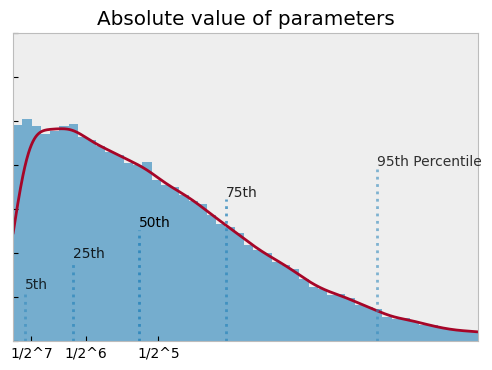

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from scipy import stats
n_bins = 100
# whats the smallest parameter in this model ?
minimum_abs_val = 100000
params_abs = []
for param in model.parameters():
  if param.abs().min() < minimum_abs_val:
    minimum_abs_val = param.abs().min()
  params_abs.extend(param.abs().detach().cpu().numpy().flatten().tolist())

print(minimum_abs_val)

xx = np.linspace(0, 0.2, 1000)

kde = stats.gaussian_kde(params_abs)
fig, ax = plt.subplots(figsize = (6,4))

ax.set_xlim(0, 0.2)

# N is the count in each bin, bins is the lower-limit of the bin
N, bins, patches = ax.hist(params_abs, bins=n_bins, density = True, alpha =0.65)
ax.plot(xx, kde(xx))


ax.set_ylim(0, 14)
ax.set_yticklabels([])
ax.set_ylabel("")
plt.style.use("bmh")
ax.set_xticks([1.0/128.0, 1.0/32.0, 1.0/16.0])
ax.set_xticklabels(["1/2^7", "1/2^6", "1/2^5"])
ax.grid(False)
# Calculate percentiles
quant_5, quant_25, quant_50, quant_75, quant_95 = np.quantile(params_abs, 0.05), np.quantile(params_abs, 0.25), np.quantile(params_abs, 0.5), np.quantile(params_abs, 0.75), np.quantile(params_abs, 0.95)

# [quantile, opacity, length]
quants = [[quant_5, 0.6, 0.16], [quant_25, 0.8, 0.26], [quant_50, 1, 0.36],  [quant_75, 0.8, 0.46], [quant_95, 0.6, 0.56]]

# Plot the lines with a loop
for i in quants:
    ax.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":")

# Annotations
ax.text(quant_5, 14 * 0.17, "5th", size = 10, alpha = 0.8)
ax.text(quant_25, 14 * 0.27, "25th", size = 10, alpha = 0.85)
ax.text(quant_50, 14 * 0.37, "50th", size = 10, alpha = 1)
ax.text(quant_75, 14 * 0.47, "75th", size = 10, alpha = 0.85)
ax.text(quant_95, 14 * 0.57, "95th Percentile", size = 10, alpha =.8)

ax.set_title("Absolute value of parameters")

In [4]:
import os

model_path = os.path.join('network_lenet.onnx')
compiled_model_path = os.path.join('network.compiled')
pk_path = os.path.join('key.pk')
vk_path = os.path.join('key.vk')
settings_path = os.path.join('settings.json')
witness_path = os.path.join('witness.json')
data_path = os.path.join('input.json')

In [5]:
import torch
import json

model.eval()  # Set the model to evaluation mode

# # Fetch a single data point from the train_dataset
# # Ensure train_dataset is already loaded and accessible
train_data_point, _ = next(iter(train_dataset))
train_data_point = train_data_point.unsqueeze(0)  # Add a batch dimension

# Verify the device (CPU or CUDA) and transfer the data point to the same device as the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_data_point = train_data_point.to(device)

# # Export the model to ONNX format
torch.onnx.export(model, train_data_point, model_path, export_params=True, opset_version=12, do_constant_folding=True, input_names=['input_0'], output_names=['output'])

# Convert the tensor to numpy array and reshape it for JSON serialization
x = train_data_point.cpu().detach().numpy().reshape([-1]).tolist()
data = {'input_data': [x]}
with open('input.json', 'w') as f:
    json.dump(data, f)

print(f"Model exported to {model_path} and input data saved to input.json")

Model exported to network_lenet.onnx and input data saved to input.json


In [29]:
import ezkl

run_args = ezkl.PyRunArgs()
run_args.input_visibility = "private"
run_args.param_visibility = "fixed"
run_args.output_visibility = "public"
run_args.num_inner_cols = 2
run_args.input_scale = 4
run_args.param_scale = 4
run_args.variables = [("batch_size", 1)]

# Capture set of data points
num_data_points = 8

# Fetch 30 data points from the train_dataset
data_points = []
for i, (data_point, _) in enumerate(train_dataset):
    if i >= num_data_points:
        break
    data_points.append(data_point)

# Stack the data points to create a batch
train_data_batch = torch.stack(data_points)

# Add a batch dimension if not already present
if train_data_batch.dim() == 3:
    train_data_batch = train_data_batch.unsqueeze(0)

x = train_data_batch.cpu().detach().numpy().reshape([-1]).tolist()

data = dict(input_data = [x])

cal_path = os.path.join('cal_data.json')

# Serialize data into file:
json.dump( data, open(cal_path, 'w' ))

!RUST_LOG=trace
# TODO: Dictionary outputs
res = ezkl.gen_settings(model_path, settings_path, py_run_args=run_args)
assert res == True

res = await ezkl.calibrate_settings(cal_path, model_path, settings_path, "resources", scales=[2,7])
assert res == True

INFO ezkl.execute 2024-06-22 22:04:02,034 execute.rs:1037 num calibration batches: 8
WARNING ezkl.circuit.table 2024-06-22 22:04:11,904 table.rs:165 Using 2 columns for non-linearity table.
WARNING ezkl.circuit.table 2024-06-22 22:04:11,906 table.rs:165 Using 2 columns for non-linearity table.
WARNING ezkl.circuit.table 2024-06-22 22:04:11,908 table.rs:165 Using 4 columns for non-linearity table.
WARNING ezkl.circuit.table 2024-06-22 22:04:11,909 table.rs:165 Using 4 columns for non-linearity table.
WARNING ezkl.circuit.table 2024-06-22 22:04:11,911 table.rs:165 Using 4 columns for non-linearity table.
WARNING ezkl.circuit.table 2024-06-22 22:04:11,913 table.rs:165 Using 4 columns for non-linearity table.
WARNING ezkl.circuit.table 2024-06-22 22:04:20,015 table.rs:165 Using 2 columns for non-linearity table.
WARNING ezkl.circuit.table 2024-06-22 22:04:20,017 table.rs:165 Using 4 columns for non-linearity table.
WARNING ezkl.circuit.table 2024-06-22 22:04:20,021 table.rs:165 Using 4 col

In [29]:
res = ezkl.compile_circuit(model_path, compiled_model_path, settings_path)
assert res == True

In [30]:
# srs path
res = await ezkl.get_srs(settings_path)

INFO ezkl.execute 2024-06-21 22:30:09,310 execute.rs:741 SRS already exists at that path
INFO ezkl.execute 2024-06-21 22:30:09,321 execute.rs:639 read 16777476 bytes from file (vector of len = 16777476)
INFO ezkl.execute 2024-06-21 22:30:09,333 execute.rs:646 file hash: 41509f380362a8d14401c5ae92073154922fe23e45459ce6f696f58607655db7


In [31]:
# now generate the witness file
witness_path = "witness.json"

res = await ezkl.gen_witness(data_path, compiled_model_path, witness_path)
assert os.path.isfile(witness_path)

In [32]:
res = ezkl.mock(witness_path, compiled_model_path)
assert res == True

INFO ezkl.execute 2024-06-21 22:30:12,118 execute.rs:1403 Mock proof
INFO ezkl.graph.model 2024-06-21 22:30:12,180 model.rs:1097 model layout...


In [33]:

# HERE WE SETUP THE CIRCUIT PARAMS
# WE GOT KEYS
# WE GOT CIRCUIT PARAMETERS
# EVERYTHING ANYONE HAS EVER NEEDED FOR ZK

res = ezkl.setup(
        compiled_model_path,
        vk_path,
        pk_path,
    )

assert res == True
assert os.path.isfile(vk_path)
assert os.path.isfile(pk_path)
assert os.path.isfile(settings_path)

INFO ezkl.graph.model 2024-06-21 22:30:18,435 model.rs:1097 model layout...
INFO ezkl.pfsys 2024-06-21 22:30:27,205 mod.rs:520 VK took 8.788
INFO ezkl.graph.model 2024-06-21 22:30:27,224 model.rs:1097 model layout...
INFO ezkl.pfsys 2024-06-21 22:30:34,653 mod.rs:526 PK took 7.446
INFO ezkl.pfsys 2024-06-21 22:30:34,657 mod.rs:844 done saving verification key ✅
INFO ezkl.pfsys 2024-06-21 22:30:37,110 mod.rs:827 done saving proving key ✅


In [34]:
# GENERATE A PROOF


proof_path = os.path.join('test.pf')

res = ezkl.prove(
        witness_path,
        compiled_model_path,
        pk_path,
        proof_path,
        "single",
    )

print(res)
assert os.path.isfile(proof_path)

INFO ezkl.pfsys 2024-06-21 22:30:44,709 mod.rs:810 loaded proving key ✅
INFO ezkl.pfsys 2024-06-21 22:30:44,729 mod.rs:581 proof started...
INFO ezkl.graph.model 2024-06-21 22:30:44,777 model.rs:1097 model layout...
INFO ezkl.pfsys 2024-06-21 22:31:12,944 mod.rs:620 proof took 28.213


{'instances': [['43afffef93f5e1439170b97948e833285d588181b64550b829a031e1724e6430', '64d0ffef93f5e1439170b97948e833285d588181b64550b829a031e1724e6430', '40b4ffef93f5e1439170b97948e833285d588181b64550b829a031e1724e6430', '2a53000000000000000000000000000000000000000000000000000000000000', '087cffef93f5e1439170b97948e833285d588181b64550b829a031e1724e6430', '2e6e000000000000000000000000000000000000000000000000000000000000', 'b9a9ffef93f5e1439170b97948e833285d588181b64550b829a031e1724e6430', '06cfffef93f5e1439170b97948e833285d588181b64550b829a031e1724e6430', '33e4ffef93f5e1439170b97948e833285d588181b64550b829a031e1724e6430', '7eeeffef93f5e1439170b97948e833285d588181b64550b829a031e1724e6430']], 'proof': '0x0e30947ae087211ae4c22aabe4ce0d52b8b187a8da51dbae7e6ef3b09bc89f7f2420caca5ce55cff987d8e6e9c8e841640e6c281aab784ed020cf05adec35e2b2c074394b836d7030fe36e1a5008e60a845ec31361648e372ed1de9a2d4614c11088ac4542edf57e1a181568b93265679cf3ae0a9e9ec4c34c46aa3d6665cfe1209edbb5e0d52751579b53f4894808786d

In [15]:
# VERIFY IT
res = ezkl.verify(
        proof_path,
        settings_path,
        vk_path,
    )

assert res == True
print("verified")

INFO ezkl.pfsys 2024-06-21 21:55:18,453 mod.rs:787 loaded verification key ✅
INFO ezkl.execute 2024-06-21 21:55:18,462 execute.rs:2453 verify took 0.6
INFO ezkl.execute 2024-06-21 21:55:18,463 execute.rs:2458 verified: true


verified


We can now create an EVM / `.sol` verifier that can be deployed on chain to verify submitted proofs using a view function.


In [ ]:

abi_path = 'test.abi'
sol_code_path = 'test_1.sol'

res = await ezkl.create_evm_verifier(
        vk_path,
        settings_path,
        sol_code_path,
        abi_path,
    )
assert res == True

## Proof generation time


In [14]:
run_args = ezkl.PyRunArgs()
run_args.num_inner_cols = 2
run_args.input_visibility = "private"
run_args.param_visibility = "fixed"
run_args.output_visibility = "public"
run_args.input_scale = 12
run_args.param_scale = run_args.input_scale
run_args.variables = [("batch_size", 1)]

# Capture set of data points
num_data_points = 8

# Fetch 30 data points from the train_dataset
data_points = []
for i, (data_point, _) in enumerate(train_dataset):
    if i >= num_data_points:
        break
    data_points.append(data_point)

# Stack the data points to create a batch
train_data_batch = torch.stack(data_points)

# Add a batch dimension if not already present
if train_data_batch.dim() == 3:
    train_data_batch = train_data_batch.unsqueeze(0)

x = train_data_batch.cpu().detach().numpy().reshape([-1]).tolist()

data = dict(input_data = [x])

cal_path = os.path.join('cal_data.json')

# Serialize data into file:
json.dump( data, open(cal_path, 'w' ))

!RUST_LOG=trace
# TODO: Dictionary outputs
res = ezkl.gen_settings(model_path, settings_path, py_run_args=run_args)
assert res == True

res = await ezkl.calibrate_settings(cal_path, model_path, settings_path, "resources", scales=[run_args.input_scale])
# res = await ezkl.calibrate_settings(cal_path, model_path, settings_path, "resources")
assert res == True

res = ezkl.compile_circuit(model_path, compiled_model_path, settings_path)
assert res == True

res = await ezkl.get_srs(settings_path)
assert res == True

witness_path = "witness.json"
# INFO ezkl.pfsys 2024-06-21 21:54:54,053 mod.rs:620 proof took 25.344


res = await ezkl.gen_witness(data_path, compiled_model_path, witness_path)
assert os.path.isfile(witness_path)

res = ezkl.setup(
        compiled_model_path,
        vk_path,
        pk_path,
    )

assert res == True
assert os.path.isfile(vk_path)
assert os.path.isfile(pk_path)
assert os.path.isfile(settings_path)
print(f"!!pk size = {os.path.getsize(pk_path) / (1024*1024)}")
print(f"!!vk size = {os.path.getsize(vk_path) / (1024*1024)}")


proof_path = os.path.join('test.pf')

res = ezkl.prove(
        witness_path,
        compiled_model_path,
        pk_path,
        proof_path,
        "single",
    )

print(res)
assert os.path.isfile(proof_path)

res = ezkl.verify(
        proof_path,
        settings_path,
        vk_path,
    )

assert res == True
print("verified")